In [38]:
import pandas as pd

In [123]:
# Load dataset
df = pd.read_csv('train_v9rqX0R.csv')
print("Data shape:", df.shape)
df.head()

Data shape: (8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [124]:
df.info()
#Null value counnt
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Data Cleanup, Missing value analysis and imputation

### Outlet Size and Item weight has high missing values, let's check them out.

In [125]:
# Checking if Outlet Identifier can help interpolating Outlet Size

df.groupby(['Outlet_Identifier', 'Outlet_Size'])['Outlet_Size'].value_counts()

Outlet_Identifier  Outlet_Size
OUT013             High           932
OUT018             Medium         928
OUT019             Small          528
OUT027             Medium         935
OUT035             Small          930
OUT046             Small          930
OUT049             Medium         930
Name: count, dtype: int64

In [126]:
df[df['Outlet_Size'].isnull()]['Outlet_Identifier'].unique() # For these outlet we do not have size

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [127]:
### No, we do not have sizes for specific outlets ['OUT010', 'OUT045', 'OUT017'] at all, let's try with outlet type

In [128]:
df.groupby(['Outlet_Identifier','Outlet_Type'])['Outlet_Type'].value_counts() 

Outlet_Identifier  Outlet_Type      
OUT010             Grocery Store        555
OUT013             Supermarket Type1    932
OUT017             Supermarket Type1    926
OUT018             Supermarket Type2    928
OUT019             Grocery Store        528
OUT027             Supermarket Type3    935
OUT035             Supermarket Type1    930
OUT045             Supermarket Type1    929
OUT046             Supermarket Type1    930
OUT049             Supermarket Type1    930
Name: count, dtype: int64

#### So, let's try to interpolate missing outlet size by mode value based on outlet type.

In [129]:
size_mode = df.pivot_table(values='Item_Outlet_Sales', index='Outlet_Type', columns='Outlet_Size', aggfunc='count')

In [130]:
size_mode = size_mode.idxmax(axis=1).to_dict()

In [131]:
size_mode

{'Grocery Store': 'Small',
 'Supermarket Type1': 'Small',
 'Supermarket Type2': 'Medium',
 'Supermarket Type3': 'Medium'}

In [132]:
df['Outlet_Size'] = df.apply(
    lambda x: size_mode[x['Outlet_Type']] if pd.isnull(x['Outlet_Size']) else x['Outlet_Size'], axis=1)

In [133]:
df.groupby(['Outlet_Identifier', 'Outlet_Size'])['Outlet_Size'].value_counts()

Outlet_Identifier  Outlet_Size
OUT010             Small          555
OUT013             High           932
OUT017             Small          926
OUT018             Medium         928
OUT019             Small          528
OUT027             Medium         935
OUT035             Small          930
OUT045             Small          929
OUT046             Small          930
OUT049             Medium         930
Name: count, dtype: int64

In [134]:
df['Outlet_Size'].isnull().sum()

np.int64(0)

### Let's check for Item Weight now..

In [135]:
itemwise_avg_weight = df.groupby('Item_Identifier')['Item_Weight'].mean()

In [136]:
itemwise_avg_weight

Item_Identifier
DRA12    11.600
DRA24    19.350
DRA59     8.270
DRB01     7.390
DRB13     6.115
          ...  
NCZ30     6.590
NCZ41    19.850
NCZ42    10.500
NCZ53     9.600
NCZ54    14.650
Name: Item_Weight, Length: 1559, dtype: float64

In [137]:
# Let's try imputing Item Weight by averaage weight of the same Item_Identifier

In [138]:
missing_before = df['Item_Weight'].isna().sum()
df['Item_Weight'] = df.apply(
    lambda x: itemwise_avg_weight[x['Item_Identifier']] if pd.isna(x['Item_Weight']) else x['Item_Weight'], axis=1)
missing_after = df['Item_Weight'].isna().sum()
print(f"Missing Item_Weight before: {missing_before}, after imputation: {missing_after}")

Missing Item_Weight before: 1463, after imputation: 4


In [139]:
# Great!just 4 missing now, imputing with median weight.
overall_median_weight = df['Item_Weight'].median()
df['Item_Weight'].fillna(overall_median_weight, inplace=True)

C:\Users\INASSRI3\AppData\Local\Temp\ipykernel_37000\1102273663.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Item_Weight'].fillna(overall_median_weight, inplace=True)


In [140]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [141]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [142]:
#LF, low fat , Low Fat -> should be same.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat','low fat': 'Low Fat','reg': 'Regular'})

In [143]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [144]:
df['Outlet_Age'] = 2013 - df['Outlet_Establishment_Year']

In [171]:
df.to_csv("train.csv", index=False)

# EDA

In [145]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Age
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.875314,0.066132,140.992782,1997.831867,2181.288914,15.168133
std,4.645010,0.051598,62.275067,8.371760,1706.499616,8.371760
min,4.555000,0.000000,31.290000,1985.000000,33.290000,4.000000
25%,8.785000,0.026989,93.826500,1987.000000,834.247400,9.000000
50%,12.650000,0.053931,143.012800,1999.000000,1794.331000,14.000000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400,26.000000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,28.000000


In [146]:
#item visibility 0? and still sold? lets see..
len(df[df['Item_Visibility'] == 0]) # 526 items with 0 visibility and sold. This looks incorrect data entry. 

526

In [147]:
#Are these items small value items? Given instead of small change?
df[df['Item_Visibility'] == 0]['Item_MRP'].median() # NO

130.24810000000002

In [148]:
# lets check categories in non numric columns
print("Item_Fat_Content unique values:", df['Item_Fat_Content'].unique())
print("Item_Type unique values (count):", df['Item_Type'].nunique())
print("Outlet_Type counts:\n", df['Outlet_Type'].value_counts())

Item_Fat_Content unique values: ['Low Fat' 'Regular']
Item_Type unique values (count): 16
Outlet_Type counts:
 Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64


In [149]:
# Category of items sold across outlets
df.Item_Type.value_counts()

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

In [150]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

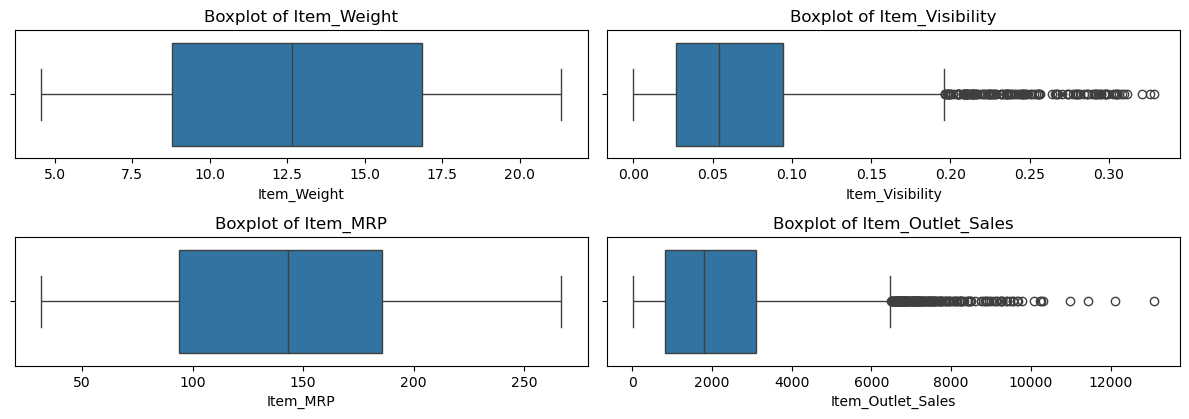

In [151]:
# List of numerical features to check for outliers
numeric_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

#boxplots for each numerical feature
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [152]:
# Item Weight -> The distribution is roughly normal, and boxplot likely shows a symmetric spread.
# The boxplot shows many low-visibility items and a few with much higher visibility. Visibility of 0 is not possible and is an anomaly..
# Item_MRP looks approximately normal. and no evidence of outliers.
# Item_Outlet_Sales : The boxplot shows many points beyond the upper whisker, indicating outliers in sales. These high-sale outliers might be legitimate (e.g., food items, daily consumables) but could affect a linear model.

In [153]:
# 0 visibility outlier handling: Replace zero visibilities with the mean visibility of that item

visibility_avg = df.pivot_table(values='Item_Visibility', index='Item_Identifier', aggfunc='mean')
zero_mask = (df['Item_Visibility'] == 0)
df.loc[zero_mask, 'Item_Visibility'] = df.loc[zero_mask, 'Item_Identifier'].apply(lambda x: visibility_avg.at[x, 'Item_Visibility'])
print("Number of zero visibility entries after imputation:", (df['Item_Visibility'] == 0).sum())

Number of zero visibility entries after imputation: 0


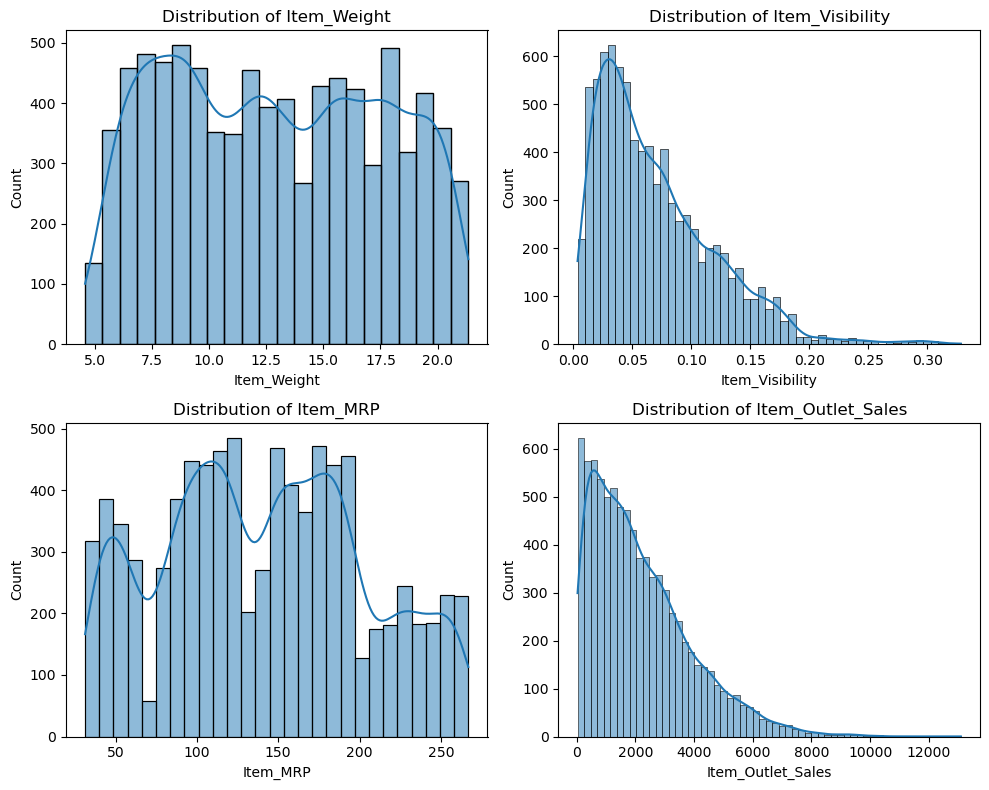

In [154]:
numeric_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
plt.figure(figsize=(10, 8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [155]:
# Log transform the target variable to reduce skewness
df['Log_Sales'] = np.log1p(df['Item_Outlet_Sales'])  # log(1+sales)

Text(0.5, 1.0, 'Distribution of Log_Sales')

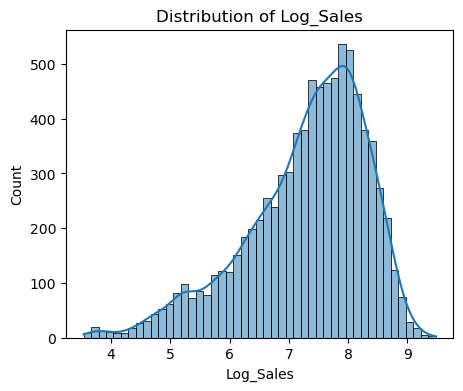

In [156]:
plt.figure(figsize=(5, 4))
# plt.subplot(2, 2)
sns.histplot(df['Log_Sales'], kde=True)
plt.title('Distribution of Log_Sales')

In [157]:
# Let's try item visibility after transformation.


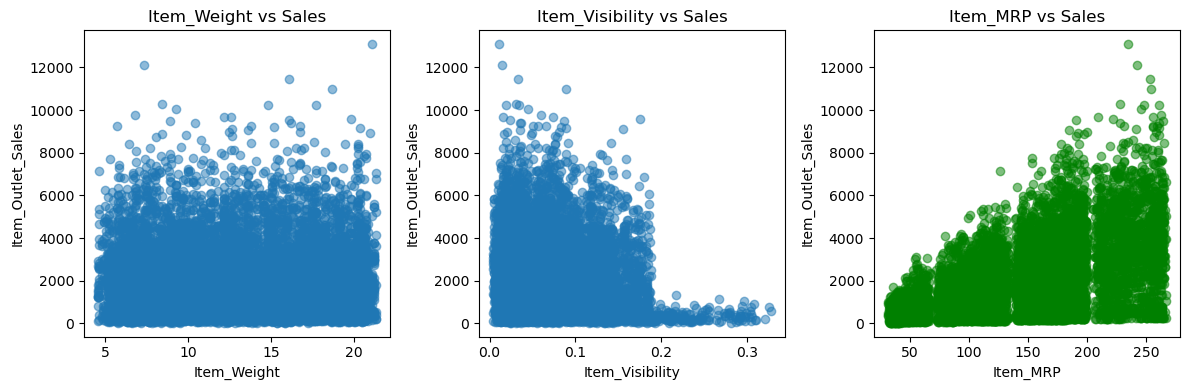

In [158]:
# Scatter plots for numerical features vs target
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(df['Item_Weight'], df['Item_Outlet_Sales'], alpha=0.5)
plt.title('Item_Weight vs Sales')
plt.xlabel('Item_Weight')
plt.ylabel('Item_Outlet_Sales')

plt.subplot(1, 3, 2)
plt.scatter(df['Item_Visibility'], df['Item_Outlet_Sales'], alpha=0.5)
plt.title('Item_Visibility vs Sales')
plt.xlabel('Item_Visibility')
plt.ylabel('Item_Outlet_Sales')

plt.subplot(1, 3, 3)
plt.scatter(df['Item_MRP'], df['Item_Outlet_Sales'], alpha=0.5, c='green')
plt.title('Item_MRP vs Sales')
plt.xlabel('Item_MRP')
plt.ylabel('Item_Outlet_Sales')
plt.tight_layout()
plt.show()


In [159]:
# Item weight and sales -> widely scattered.
# Item Visibility and sales -> Slight abnormal trend.. at higher visibility sales is shown as decreasing, surprising..
# Item MRP and sales -> positive correlation but not linear..

                   Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  \
Item_Weight           1.000000        -0.017881  0.025986           0.013162   
Item_Visibility      -0.017881         1.000000 -0.004525          -0.128449   
Item_MRP              0.025986        -0.004525  1.000000           0.567574   
Item_Outlet_Sales     0.013162        -0.128449  0.567574           1.000000   
Log_Sales             0.007676        -0.193714  0.509886           0.861762   

                   Log_Sales  
Item_Weight         0.007676  
Item_Visibility    -0.193714  
Item_MRP            0.509886  
Item_Outlet_Sales   0.861762  
Log_Sales           1.000000  


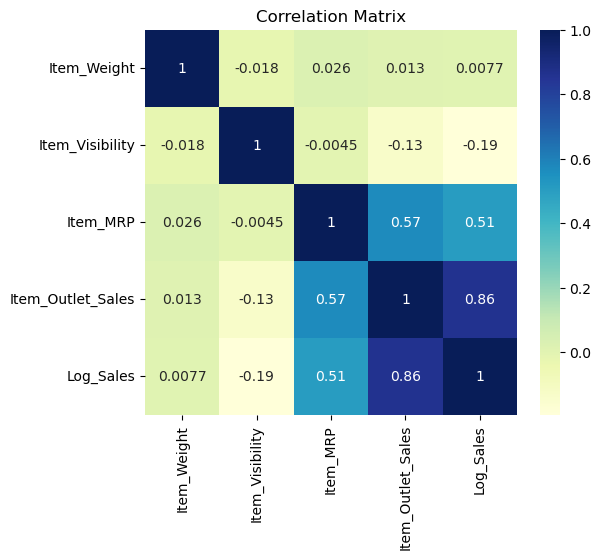

In [161]:
# Compute correlation matrix for numeric features (including transformed sales)
corr_matrix = df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales', 'Log_Sales']].corr()
print(corr_matrix)

# Plotting a heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()


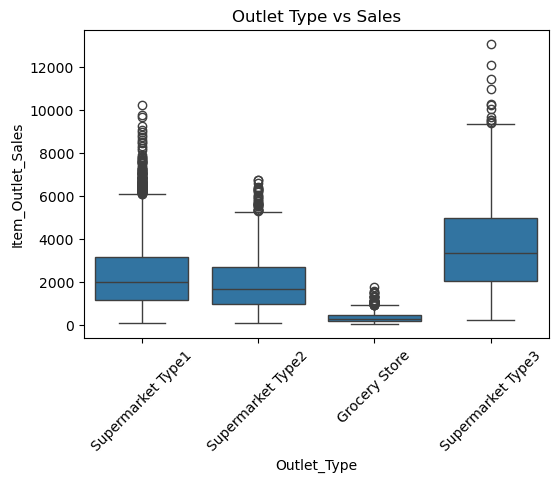

In [162]:
# Boxplot of Sales by Outlet_Type
plt.figure(figsize=(6,4))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df)
plt.title('Outlet Type vs Sales')
plt.xticks(rotation=45)
plt.show()


In [163]:
# Supermarket Type3 outlets have a much higher median sales compared to Type1, Type2, or Grocery Stores. Grocery stores likely have the lowest sales. 
# This indicates outlet type is a strong factor in sales lets try checking with ANOVA).
# Outlet_Size might show that larger stores (High/Medium) have higher sales than Small ones, Grocry stores are Small stores..

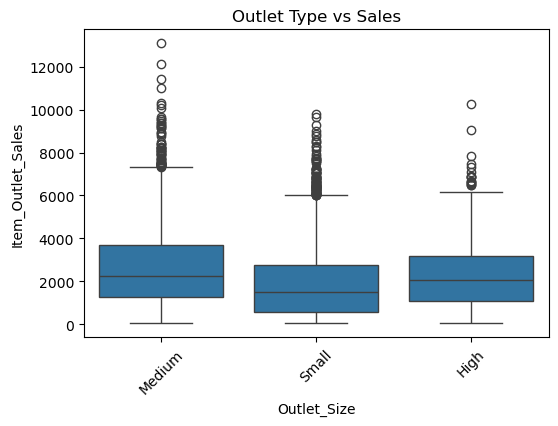

In [164]:
# Boxplot of Sales by Outlet_Size
plt.figure(figsize=(6,4))
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df)
plt.title('Outlet Type vs Sales')
plt.xticks(rotation=45)
plt.show()

In [165]:
# Not significant difference as we had in Outlet type..

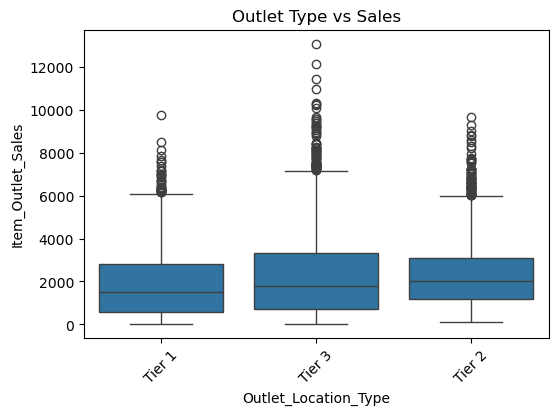

In [166]:
# Boxplot of Sales by Outlet_Location
plt.figure(figsize=(6,4))
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df)
plt.title('Outlet Type vs Sales')
plt.xticks(rotation=45)
plt.show()

In [167]:
# Expected Tier 1 sales to be higher than 2/3. Proved wrong.

In [168]:
from scipy.stats import pearsonr
# Example: correlation between Item_MRP and Item_Outlet_Sales
corr_coef, p_value = pearsonr(df['Item_MRP'], df['Item_Outlet_Sales'])
print("Pearson correlation between Item_MRP and Sales:", corr_coef, "p-value:", p_value)


Pearson correlation between Item_MRP and Sales: 0.5675744466569194 p-value: 0.0


In [169]:
# Multi colinearty check among variables..

from statsmodels.stats.outliers_influence import variance_inflation_factor

features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Type', 'Outlet_Location_Type']
X = pd.get_dummies(df[features], drop_first=True)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''